In [252]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
df = pd.read_csv("spotify-2023.csv", sep=",")
df.head()
target = 'artist_count'

In [253]:
#Добавление новых численных показателей (колонок)

# количество плейлистов в AM и Spotify, в которые включена песня
df['total_number_of_playlists'] = df['in_apple_playlists'] + df['in_spotify_playlists']

#Соотношение прослушиваний к числу плейлистов (spotify)
df['ratio_streams_to_playlists'] = df['streams'].astype(int) / df['in_spotify_playlists']

# колонка T/F (0/1) для бин. поиска
compare = 2 #порог для сравнения (если 1-2 исполнителя - 0, >2 => 1)
df['amount_of_artists'] = (df['artist_count'] > compare).astype(int)
df['mode'] = (df['mode'] == 'Major').astype(int)
df.head()


,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,total_number_of_playlists,ratio_streams_to_playlists,amount_of_artists
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,80,89,83,31,0,8,4,596,255663.115732,0
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,71,61,74,7,0,10,4,1522,90716.611940,0
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,51,32,53,17,0,31,6,1491,100217.590551,0
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,55,58,72,11,0,11,15,7974,101914.076992,0
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,65,23,80,14,63,11,6,3217,96787.846154,0


In [183]:
#Удаление с оконулевой дисперсией

numeric_columns = df.select_dtypes(include=['number']).drop(columns=[target,'amount_of_artists'])
count = 1 #порог
variances = numeric_columns.var() #считаем дисперсию
drop = [] #удалённые колонки
for i in numeric_columns.columns:
    if numeric_columns[i].var() < count:
        drop.append(i)
df_filtered = df.drop(columns=drop) #обновлённый DF без колонок с дисп. ниже заданного порога
print(df_filtered)
print("\nУдалённые колонки:")
print(drop)

                              track_name      artist(s)_name  artist_count  \
0    Seven (feat. Latto) (Explicit Ver.)    Latto, Jung Kook             2   
1                                   LALA         Myke Towers             1   
2                                vampire      Olivia Rodrigo             1   
3                           Cruel Summer        Taylor Swift             1   
4                         WHERE SHE GOES           Bad Bunny             1   
..                                   ...                 ...           ...   
948                         My Mind & Me        Selena Gomez             1   
949            Bigger Than The Whole Sky        Taylor Swift             1   
950                 A Veces (feat. Feid)  Feid, Paulo Londra             2   
951                        En La De Ella  Feid, Sech, Jhayco             3   
952                                Alone           Burna Boy             1   

     released_year  released_month  released_day  in_spotify_pl

In [184]:
#Удаление с высокой корреляцией

numeric_columns = df_filtered.select_dtypes(include=['number']).drop(columns=[target,'amount_of_artists'])
correlation_threshold = 0.9 # порог корреляции
correlation_matrix = numeric_columns.corr().abs() #матрица корреляции
mask = (correlation_matrix >= correlation_threshold) & (correlation_matrix < 1.0) #создали маску для определения колл. признаков
correlated_columns = [col for col in mask.columns if any(mask[col])] #поиск имён (названий)
df_filtered.drop(correlated_columns, axis=1, inplace=True) #del
print(df_filtered)
print("\nУдалённые колонки:")
print(correlated_columns)

                              track_name      artist(s)_name  artist_count  \
0    Seven (feat. Latto) (Explicit Ver.)    Latto, Jung Kook             2   
1                                   LALA         Myke Towers             1   
2                                vampire      Olivia Rodrigo             1   
3                           Cruel Summer        Taylor Swift             1   
4                         WHERE SHE GOES           Bad Bunny             1   
..                                   ...                 ...           ...   
948                         My Mind & Me        Selena Gomez             1   
949            Bigger Than The Whole Sky        Taylor Swift             1   
950                 A Veces (feat. Feid)  Feid, Paulo Londra             2   
951                        En La De Ella  Feid, Sech, Jhayco             3   
952                                Alone           Burna Boy             1   

     released_year  released_month  released_day  in_spotify_ch

In [185]:
#Удаление выбросов по столбцу "danceability_%"

# IQR для столбца "danceability_%": насколько круто под нее танцевать (пригодность)
Q1 = df_filtered['danceability_%'].quantile(0.25)
Q3 = df_filtered['danceability_%'].quantile(0.75)
IQR = Q3 - Q1 # разница между 75 и 25 процентилями данных
# Нжний и верхний пороги для удаления выбросов
lower_threshold = Q1 - 1.5 * IQR
upper_threshold = Q3 + 1.5 * IQR
# Новый ДС с данными, находящимися в пределах порога
df_filtered = df_filtered[(df_filtered['danceability_%'] >= lower_threshold) & (df_filtered['danceability_%'] <= upper_threshold)]
print(df_filtered)

                              track_name      artist(s)_name  artist_count  \
0    Seven (feat. Latto) (Explicit Ver.)    Latto, Jung Kook             2   
1                                   LALA         Myke Towers             1   
2                                vampire      Olivia Rodrigo             1   
3                           Cruel Summer        Taylor Swift             1   
4                         WHERE SHE GOES           Bad Bunny             1   
..                                   ...                 ...           ...   
948                         My Mind & Me        Selena Gomez             1   
949            Bigger Than The Whole Sky        Taylor Swift             1   
950                 A Veces (feat. Feid)  Feid, Paulo Londra             2   
951                        En La De Ella  Feid, Sech, Jhayco             3   
952                                Alone           Burna Boy             1   

     released_year  released_month  released_day  in_spotify_ch

In [186]:
#Удаление выбросов по столбцу "streams"

# IQR для столбца "streams": Общее количество прослушиваний на Spotify
Q1 = df_filtered['streams'].quantile(0.25)
Q3 = df_filtered['streams'].quantile(0.75)
IQR = Q3 - Q1 # разница между 75 и 25 процентилями данных
# Нжний и верхний пороги для удаления выбросов
lower_threshold = Q1 - 1.5 * IQR
upper_threshold = Q3 + 1.5 * IQR
# Новый ДС с данными, находящимися в пределах порога
df_filtered = df_filtered[(df_filtered['streams'] >= lower_threshold) & (df_filtered['streams'] <= upper_threshold)]
print(df_filtered)

                              track_name      artist(s)_name  artist_count  \
0    Seven (feat. Latto) (Explicit Ver.)    Latto, Jung Kook             2   
1                                   LALA         Myke Towers             1   
2                                vampire      Olivia Rodrigo             1   
3                           Cruel Summer        Taylor Swift             1   
4                         WHERE SHE GOES           Bad Bunny             1   
..                                   ...                 ...           ...   
948                         My Mind & Me        Selena Gomez             1   
949            Bigger Than The Whole Sky        Taylor Swift             1   
950                 A Veces (feat. Feid)  Feid, Paulo Londra             2   
951                        En La De Ella  Feid, Sech, Jhayco             3   
952                                Alone           Burna Boy             1   

     released_year  released_month  released_day  in_spotify_ch

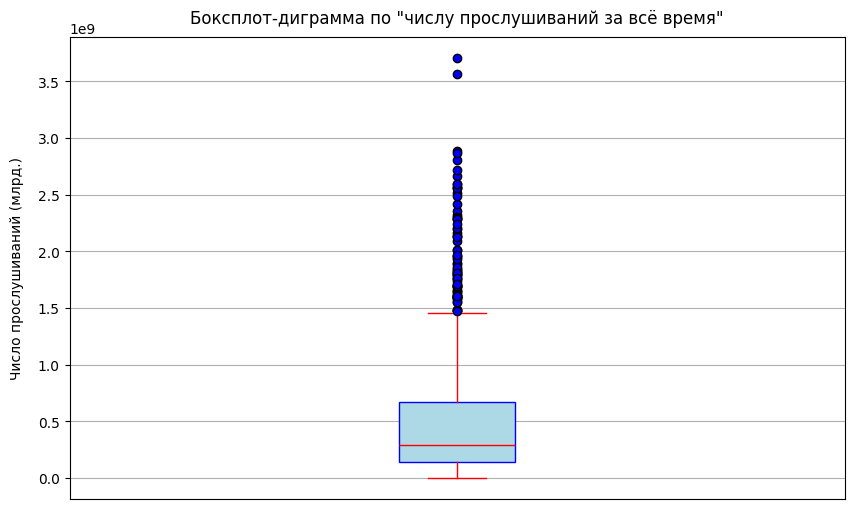

In [96]:
#boxplot для начального

streams_data = df['streams']

plt.figure(figsize=(10, 6))
bp = plt.boxplot(streams_data, showfliers=True, patch_artist=True,
                 boxprops=dict(facecolor='lightblue', color='blue'),  # Цвет самого бокса
            capprops=dict(color='red'),  # Цвет концов усов
            whiskerprops=dict(color='red'),  # Цвет "усов"
            flierprops=dict(markerfacecolor='blue'),  # Цвет выбросов
            medianprops=dict(color='red'))  # Цвет медианы)

plt.title('Боксплот-диграмма по "числу прослушиваний за всё время"',pad=10)
plt.ylabel('Число прослушиваний (млрд.)', labelpad=10)
plt.xticks([])
#plt.legend(labels=None) #- легенда
plt.grid(True) #сетка
plt.show()

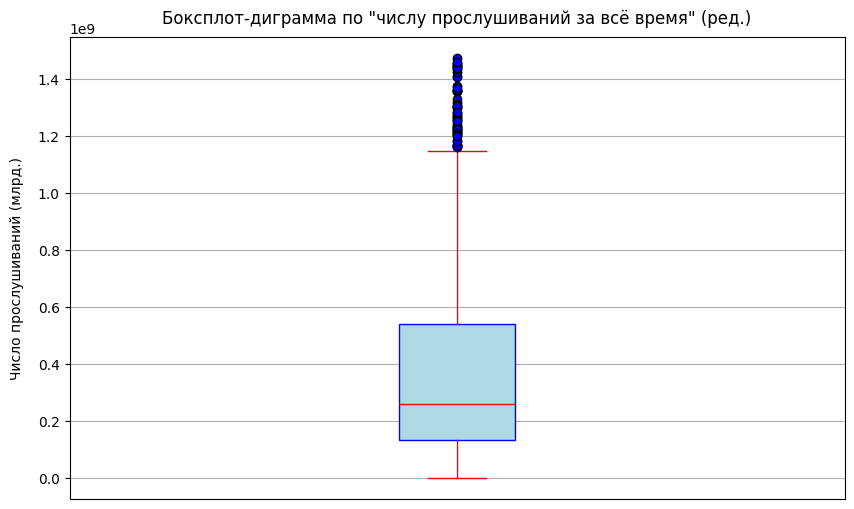

In [97]:
#boxplot для измен.

streams_data = df_filtered['streams']

plt.figure(figsize=(10, 6))
bp = plt.boxplot(streams_data, showfliers=True, patch_artist=True,
                 boxprops=dict(facecolor='lightblue', color='blue'),  # Цвет самого бокса
            capprops=dict(color='red'),  # Цвет концов усов
            whiskerprops=dict(color='red'),  # Цвет "усов"
            flierprops=dict(markerfacecolor='blue'),  # Цвет выбросов
            medianprops=dict(color='red'))  # Цвет медианы)

plt.title('Боксплот-диграмма по "числу прослушиваний за всё время" (ред.)',pad=10)
plt.ylabel('Число прослушиваний (млрд.)', labelpad=10)
plt.xticks([])
#plt.legend(labels=None) #- легенда
plt.grid(True) #сетка
plt.show()

In [243]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

columns_to_exclude = ['amount_of_artists', target]  # список на искл.
# Выбор признаков (категориальные столбцы) и целевой переменной
categorical_features = df.drop(columns=columns_to_exclude, axis=1).columns  # категор.
target_column = 'amount_of_artists' #целевая

# Преобразование категориальных признаков в числовые с помощью LabelEncoder
label_encoders = {}
for feature in categorical_features:
    le = LabelEncoder()
    df[feature] = le.fit_transform(df[feature])
    label_encoders[feature] = le

# Разделение данных на обучающий и тестовый наборы
X = df[categorical_features]
y = df[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

# Создание и обучение модели логистической регрессии
#model = LogisticRegression()
#model.fit(X_train, y_train)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Инициализируем модель SVM с линейным ядром
model = SVC(kernel='linear')
# Обучаем модель на обучающих данных
model.fit(X_train, y_train)
# Предсказание на тестовых данных
y_pred = model.predict(X_test)
#Точность
accuracy = accuracy_score(y_test, y_pred)
print("Точность модели:", round(accuracy * 100, 2), "%")

Точность модели: 90.21 %


In [245]:
columns_to_exclude = ['amount_of_artists', target]  # список на искл.
# Выбор признаков (категориальные столбцы) и целевой переменной
categorical_features = df_filtered.drop(columns=columns_to_exclude, axis=1).columns  # категор.
target_column = 'amount_of_artists' #целевая

# Преобразование категориальных признаков в числовые с помощью LabelEncoder
label_encoders = {}
for feature in categorical_features:
    le = LabelEncoder()
    df_filtered[feature] = le.fit_transform(df_filtered[feature])
    label_encoders[feature] = le

# Разделение данных на обучающий и тестовый наборы
X = df_filtered[categorical_features]
y = df_filtered[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

# Создание и обучение модели логистической регрессии
#model = LogisticRegression()
#model.fit(X_train, y_train)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# Инициализируем модель SVM с линейным ядром
model = SVC(kernel='linear')
# Обучаем модель на обучающих данных
model.fit(X_train, y_train)
# Предсказание на тестовых данных
y_pred = model.predict(X_test)
#Точность
accuracy = accuracy_score(y_test, y_pred)
print("Точность модели:", round(accuracy * 100, 2), "%")

Точность модели: 87.88 %


In [254]:
#матрицы корреляции
dfCor = df.select_dtypes(exclude=['object'])

correlation_matrix = dfCor.corr()
fig = px.imshow(correlation_matrix, x=correlation_matrix.columns, y=correlation_matrix.index, title="Корреляционная матрица изначального Датасета")
fig.show()

dfCor = df_filtered.select_dtypes(exclude=['object'])

correlation_matrix = dfCor.corr()
fig = px.imshow(correlation_matrix, x=correlation_matrix.columns, y=correlation_matrix.index, title="Корреляционная матрица изменённого Датасета")
fig.show()
